# Car Licence Plate Detection usecase with AutoML for Images

(Object Detection task) and Azure OCR

<p align="center"/>
  <img src="https://www.egenuity.com/img/images/LPR-Confirmed.jpg">
</p>

In this example, I will use the AutoML for Images to detect number plate objects in the picture, 
then pass the number plate object to the text extraction service in Azure Cognitive Services. 

## 1. Setup
> To use this notebook, **you will need to install the private preview package for AutoML for Images from the private index**.

In [1]:
#!pip install --upgrade "azureml-train-core<0.1.1" "azureml-train-automl<0.1.1" "azureml-contrib-dataset<0.1.1" --extra-index-url "https://azuremlsdktestpypi.azureedge.net/automl_for_images_private_preview/"

In [2]:
import numpy as np
import json
import os
import urllib
from zipfile import ZipFile
import seaborn as sns
import pandas as pd
from azureml.train.automl import AutoMLImageConfig
from azureml.train.hyperdrive import RandomParameterSampling
from azureml.train.hyperdrive import GridParameterSampling
from azureml.train.hyperdrive import choice

In [3]:
import sys
print("Python version =", sys.version)

Python version = 3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]


In [4]:
import datetime
now = datetime.datetime.now()
print("Today =", now)

Today = 2021-05-17 08:30:02.222959


In [5]:
import azureml.core
print("You are using Azure ML version", azureml.core.VERSION)

You are using Azure ML version 0.1.0.36312295


In [6]:
# Your local platform
import platform,socket,re,uuid,json,psutil,logging

def getSystemInfo():
    try:
        info={}
        info['Platform']=platform.system()
        info['Platform-release']=platform.release()
        info['Platform-version']=platform.version()
        info['Architecture']=platform.machine()
        info['Hostname']=socket.gethostname()
        info['IP-address']=socket.gethostbyname(socket.gethostname())
        info['MAC-address']=':'.join(re.findall('..', '%012x' % uuid.getnode()))
        info['Processor']=platform.processor()
        info['RAM']=str(round(psutil.virtual_memory().total / (1024.0 **3)))+" Go"
        return json.dumps(info)
    except Exception as e:
        logging.exception(e)

json.loads(getSystemInfo())

{'Platform': 'Linux',
 'Platform-release': '5.4.0-1043-azure',
 'Platform-version': '#45~18.04.1-Ubuntu SMP Sat Mar 20 16:16:05 UTC 2021',
 'Architecture': 'x86_64',
 'Hostname': 'computeinstancenbooks',
 'IP-address': '127.0.0.1',
 'MAC-address': '45:ac:59:ca:9f:45',
 'Processor': 'x86_64',
 'RAM': '27 Go'}

## 2. Azure ML workspace setup
In order to train and deploy models in Azure ML, you will first need to set up a workspace.

An [Azure ML Workspace](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#workspace) is an Azure resource that organizes and coordinates the actions of many other Azure resources to assist in executing and sharing machine learning workflows. In particular, an Azure ML Workspace coordinates storage, databases, and compute resources providing added functionality for machine learning experimentation, deployment, inference, and the monitoring of deployed models.

Create an Azure ML Workspace within your Azure subscription, or load an existing workspace.

In [7]:
## specify workspace parameters
subscription_id='TOBEREPLACED'   
resource_group='automlvision-rg'   
workspace_name='automlvision'

from azureml.core.workspace import Workspace
ws = Workspace.create(name=workspace_name,
                      subscription_id=subscription_id,
                      resource_group=resource_group, 
                      exist_ok=True)

In [8]:
from azureml.core import Workspace
ws = Workspace.from_config()

In [9]:
ws.name, ws.resource_group

('automlvision', 'automlvision-rg')

## 3. GPU Compute target setup
You will need to provide a [Compute Target](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#compute-target) that will be used for your AutoML model training. AutoML models for image tasks require GPU SKUs and support NC and ND families. We recommend using the NCsv3-series (with v100 GPUs) for faster training. Using a compute target with a multi-GPU VM SKU will leverage the multiple GPUs to speed up training. Additionally, setting up a compute target with multiple nodes will allow for faster model training by leveraging parallelism, when tuning hyperparameters for your model.

In [12]:
from azureml.core.compute import AmlCompute, ComputeTarget

cluster_name = "gpu-licenceplate"

try:
    compute_target = ws.compute_targets[cluster_name]
    print('Found existing compute target.')
except KeyError:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='Standard_NC24', 
                                                           idle_seconds_before_scaledown=1800,
                                                           min_nodes=1, 
                                                           max_nodes=4)

    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)
    
# Can poll for a minimum number of nodes and for a specific timeout.
# If no min_node_count is provided, it will use the scale settings for the cluster.
compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

Creating a new compute target...
Creating.........
SucceededProvisioning operation finished, operation "Succeeded"
Succeeded.............................
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


In [13]:
# Compute cluster status
compute_target.provisioning_state

'Succeeded'

In [14]:
# Compute cluster information
compute_target.get_status().serialize()

{'currentNodeCount': 1,
 'targetNodeCount': 1,
 'nodeStateCounts': {'preparingNodeCount': 1,
  'runningNodeCount': 0,
  'idleNodeCount': 0,
  'unusableNodeCount': 0,
  'leavingNodeCount': 0,
  'preemptedNodeCount': 0},
 'allocationState': 'Steady',
 'allocationStateTransitionTime': '2021-05-17T08:36:01.080000+00:00',
 'errors': None,
 'creationTime': '2021-05-17T08:32:47.160638+00:00',
 'modifiedTime': '2021-05-17T08:33:32.756878+00:00',
 'provisioningState': 'Succeeded',
 'provisioningStateTransitionTime': None,
 'scaleSettings': {'minNodeCount': 1,
  'maxNodeCount': 4,
  'nodeIdleTimeBeforeScaleDown': 'PT1800S'},
 'vmPriority': 'Dedicated',
 'vmSize': 'STANDARD_NC24'}

In [15]:
compute_target.vm_size

'STANDARD_NC24'

## 4. Experiment Setup
Create an [Experiment](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#experiment) in your workspace to track your model training runs

In [16]:
from azureml.core import Experiment

experiment_name = 'AutomlImages-LicencePlateRecognition' 
experiment = Experiment(ws, name=experiment_name)

In [17]:
experiment

Experiment(Name: AutomlImages-LicencePlateRecognition,
Workspace: automlvision)

## 5. Dataset with input Training Data
In order to generate models for computer vision, you will need to bring in labeled image data as input for model training in the form of an AzureML Labeled Dataset. You can either use a Labeled Dataset that you have exported from a Data Labeling project, or create a new Labeled Dataset with your labeled training data

**So we did the labelling part with the data labelling function of Azure ML. We saved the labelled dataset into a dataset. We labelled the location of each licence plate for each car image we have.**

In [18]:
# We can call the labelled dataset in order to identify the licence plate object
from azureml.core import Workspace, Dataset
import azureml.contrib.dataset

dataset = Dataset.get_by_name(ws, name='Licence Plates_20210507_195427') #Name of the labelled dataset
df=dataset.to_pandas_dataframe()

In [19]:
df.shape

(152, 3)

In [20]:
df

image_url  \
0    StreamInfo(AmlDatastore://cars (36).jpg[{'subs...   
1    StreamInfo(AmlDatastore://cars (148).jpg[{'sub...   
2    StreamInfo(AmlDatastore://cars (139).jpg[{'sub...   
3    StreamInfo(AmlDatastore://cars (2).jpg[{'subsc...   
4    StreamInfo(AmlDatastore://cars (108).jpg[{'sub...   
..                                                 ...   
147  StreamInfo(AmlDatastore://cars (39).jpg[{'subs...   
148  StreamInfo(AmlDatastore://cars (95).jpg[{'subs...   
149  StreamInfo(AmlDatastore://cars (141).jpg[{'sub...   
150  StreamInfo(AmlDatastore://cars (145).jpg[{'sub...   
151  StreamInfo(AmlDatastore://cars (135).jpg[{'sub...   

                                                 label label_confidence  
0    [{'label': 'LicencePlate', 'topX': 0.397788621...            [1.0]  
1    [{'label': 'LicencePlate', 'topX': 0.373953603...            [1.0]  
2    [{'label': 'LicencePlate', 'topX': 0.428437145...            [1.0]  
3    [{'label': 'LicencePlate', 'topX': 0.506757236...            [1.0]  
4    [{'label': 'LicencePlate', 'topX': 0.454267026...            [1.0]  
..                                                 ...              ...  
147  [{'label': 'LicencePlate', 'topX': 0.166058899...            [1.0]  
148  [{'label': 'LicencePlate', 'topX': 0.435440891...            [1.0]  
149  [{'label': 'LicencePlate', 'topX': 0.430707292...            [1.0]  
150  [{'label': 'LicencePlate', 'topX': 0.367143161...            [1.0]  
151  [{'label': 'LicencePlate', 'topX': 0.360332718...            [1.0]  

[152 rows x 3 columns]

> We can see the object we want to detect (LicencePlate) and the region for each image in the label column

In [21]:
training_dataset=dataset

## 6. Configuring your AutoML run for image tasks
AutoML allows you to easily train models for Image Classification, Object Detection & Instance Segmentation on your image data. You can control the model algorithm to be used, specify hyperparameter values for your model as well as perform a sweep across the hyperparameter space to generate an optimal model. Parameters for configuring your AutoML runs for image related tasks are specified using the `AutoMLImageConfig` - please refer to the [documentation](https://github.com/swatig007/automlForImages/blob/main/README.md) for the details on the parameters that can be used and their values.

When using AutoML for image tasks, you need to specify the model algorithms using the `model_name` parameter. You can either specify a single model or choose to sweep over multiple ones. 
Currently supported model algorithms for object detection:`yolov5`, `fasterrcnn_resnet50_fpn`, `fasterrcnn_resnet34_fpn`, `fasterrcnn_resnet18_fpn`, `retinanet_resnet50_fpn`.

### Using default hyperparameter values for the specified algorithm
Before doing a large sweep to search for the optimal models and hyperparameters, we recommend trying the default values to get a first baseline. Next, you can explore multiple hyperparameters for the same model before sweeping over multiple models and their parameters. This is for employing a more iterative approach, because with multiple models and multiple hyperparameters for each (as we showcase in the next section), the search space grows exponentially and you need more iterations to find optimal configurations.

**If you wish to use the default hyperparameter values for a given algorithm (say `yolov5`), you can specify the config for your AutoML Image runs as follows:**

In [23]:
from azureml.train.automl import AutoMLImageConfig
from azureml.train.hyperdrive import GridParameterSampling
from azureml.train.hyperdrive import choice

image_config_yolov5 = AutoMLImageConfig(task='image-object-detection',
                                        compute_target=compute_target,
                                        training_data=training_dataset,
                                        hyperparameter_sampling=GridParameterSampling({'model_name': choice('yolov5')}))

### Submitting an AutoML run for Image tasks 
Once you've created the config settings for your run, you can submit an AutoML run using the config in order to train an image model using your training dataset.

In [24]:
automl_image_run = experiment.submit(image_config_yolov5)

Submitting remote run.


In [25]:
automl_image_run.wait_for_completion(wait_post_processing=True)

{'runId': 'AutoML_b69e18e1-0d39-483c-bd08-1012baf1cdc9',
 'target': 'gpu-licenceplate',
 'status': 'Completed',
 'startTimeUtc': '2021-05-17T08:37:34.971853Z',
 'endTimeUtc': '2021-05-17T08:50:53.408381Z',
 'properties': {'num_iterations': '1',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'mean_average_precision',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': None,
  'target': 'gpu-licenceplate',
  'AMLSettingsJsonString': '{"path":null,"name":"AutomlImages-LicencePlateRecognition","subscription_id":"70b8f39e-8863-49f7-b6ba-34a80799550c","resource_group":"automlvision-rg","workspace_name":"automlvision","region":"westeurope","compute_target":"gpu-licenceplate","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"enable_batch_run":false,"enable_run_restructure":false,"start_auxiliary_runs_before_parent_complete":false,"iterations":1,"primary_metric":"mean_average_prec

In [26]:
experiment

Experiment(Name: AutomlImages-LicencePlateRecognition,
Workspace: automlvision)

In [27]:
# List of all the AutoML for Images metrics values
automlvisionmetrics = automl_image_run.get_metrics()
metricsdf=pd.DataFrame(automl_image_run.get_metrics()) # Convert to a pandas df

In [28]:
metricsdf.sort_values(by='mean_average_precision', ascending=False)

precision                                  per_label_metrics  recall  \
21      0.969  {0: {'precision': 0.969, 'recall': 1.0, 'avera...   1.000   
20      0.939  {0: {'precision': 0.939, 'recall': 1.0, 'avera...   1.000   
18      0.861  {0: {'precision': 0.861, 'recall': 1.0, 'avera...   1.000   
17      0.939  {0: {'precision': 0.939, 'recall': 1.0, 'avera...   1.000   
16      0.939  {0: {'precision': 0.939, 'recall': 1.0, 'avera...   1.000   
15      0.816  {0: {'precision': 0.816, 'recall': 1.0, 'avera...   1.000   
19      0.939  {0: {'precision': 0.939, 'recall': 1.0, 'avera...   1.000   
13      0.689  {0: {'precision': 0.689, 'recall': 1.0, 'avera...   1.000   
14      0.816  {0: {'precision': 0.816, 'recall': 1.0, 'avera...   1.000   
9       0.211  {0: {'precision': 0.211, 'recall': 1.0, 'avera...   1.000   
12      0.674  {0: {'precision': 0.674, 'recall': 1.0, 'avera...   1.000   
7       0.181  {0: {'precision': 0.181, 'recall': 1.0, 'avera...   1.000   
8       0.137  {0: {'precision': 0.137, 'recall': 1.0, 'avera...   1.000   
10      0.500  {0: {'precision': 0.5, 'recall': 1.0, 'average...   1.000   
11      0.403  {0: {'precision': 0.403, 'recall': 1.0, 'avera...   1.000   
6       0.100  {0: {'precision': 0.1, 'recall': 1.0, 'average...   1.000   
5       0.040  {0: {'precision': 0.04, 'recall': 1.0, 'averag...   1.000   
4       0.018  {0: {'precision': 0.018, 'recall': 0.613, 'ave...   0.613   
2       0.007  {0: {'precision': 0.007, 'recall': 0.129, 'ave...   0.129   
1         NaN  {0: {'precision': -1.0, 'recall': 0.0, 'averag...   0.000   
3       0.000  {0: {'precision': 0.0, 'recall': 0.0, 'average...   0.000   
0         NaN  {0: {'precision': -1.0, 'recall': 0.0, 'averag...   0.000   

    mean_average_precision  
21                   1.000  
20                   1.000  
18                   1.000  
17                   1.000  
16                   1.000  
15                   1.000  
19                   0.999  
13                   0.998  
14                   0.992  
9                    0.989  
12                   0.978  
7                    0.962  
8                    0.956  
10                   0.956  
11                   0.905  
6                    0.848  
5                    0.759  
4                    0.111  
2                    0.004  
1                    0.000  
3                    0.000  
0                    0.000

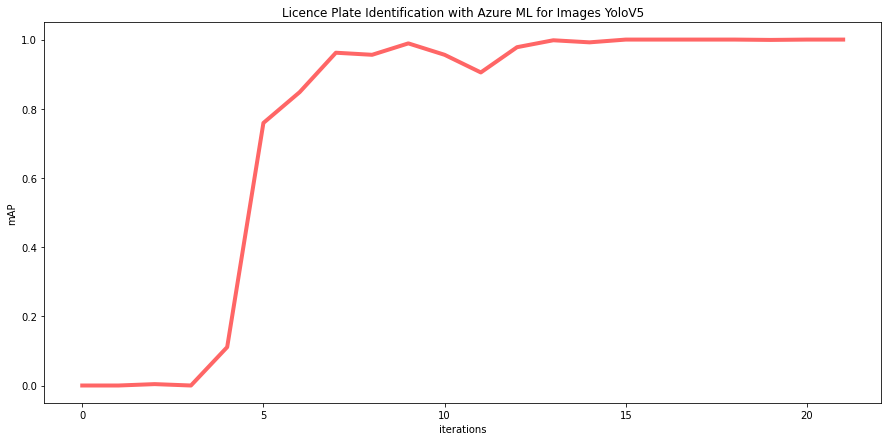

In [32]:
# Let's plot the accuracy metric for the CV model, save the graph to a jpg file and log it to the Azure ML experiment
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize = (15,7))
plt.plot(automlvisionmetrics['mean_average_precision'], 'r-', lw=4, alpha=.6)
plt.xlabel('iterations', fontsize=10)
plt.ylabel('mAP', fontsize=10)
plt.title('Licence Plate Identification with Azure ML for Images YoloV5', fontsize=12)

plt.savefig('licenceplate_mAP_yolov5.jpg', dpi=150) # Saving image into a jpg file
automl_image_run.log_image(name='licenceplate_mAP_yolov5.jpg', plot=plt) # Logging the graph into the Azure ML experiment

plt.show()

In [33]:
!ls licenceplate_mAP_yolov5.jpg -l

-rwxrwxrwx 1 root root 99903 May 17 08:54 licenceplate_mAP_yolov5.jpg


In [34]:
from azureml.core import Run
hyperdrive_run = Run(experiment=experiment, run_id=automl_image_run.id + '_HD')
hyperdrive_run

Run(Experiment: AutomlImages-LicencePlateRecognition,
Id: AutoML_b69e18e1-0d39-483c-bd08-1012baf1cdc9_HD,
Type: hyperdrive,
Status: Completed)

## 7. Register the optimal model from the AutoML run
Once the run completes, we can register the model that was created from the best run (configuration that resulted in the best primary metric)

In [35]:
# Defining tags for the custom vision model
cvmodel_tags={"Data": "Images", 
              "Context" : "Car Licence Plate Recognition",
              "Computer Vision" : "True",
              "Task" : "Best AutoML Images",
              "Framework" : "AzureML AutoML for Images",
              "AutoML Metric" : "mAP"}

In [36]:
# Register the model from the best run
best_child_run = automl_image_run.get_best_child()
model_name = best_child_run.properties['model_name']

model = best_child_run.register_model(model_name = model_name, 
                                      model_path='outputs/model.pt',
                                      tags=cvmodel_tags,
                                      description="Car Licence Plate detection")

In [37]:
model

Model(workspace=Workspace.create(name='automlvision', subscription_id='70b8f39e-8863-49f7-b6ba-34a80799550c', resource_group='automlvision-rg'), name=AutoMLb69e18e100, id=AutoMLb69e18e100:1, version=1, tags={'Data': 'Images', 'Context': 'Car Licence Plate Recognition', 'Computer Vision': 'True', 'Task': 'Best AutoML Images', 'Framework': 'AzureML AutoML for Images', 'AutoML Metric': 'mAP'}, properties={})

In [38]:
model.id

'AutoMLb69e18e100:1'

In [39]:
model.tags

{'Data': 'Images',
 'Context': 'Car Licence Plate Recognition',
 'Computer Vision': 'True',
 'Task': 'Best AutoML Images',
 'Framework': 'AzureML AutoML for Images',
 'AutoML Metric': 'mAP'}

In [40]:
# We can download the CV model
model.download(target_dir='.', exist_ok=True)

'model.pt'

In [42]:
# Checking the downloaded file
!ls *.pt -l

-rwxrwxrwx 1 root root 172310848 May 17 08:55 model.pt


## 8. Deploy model as a web service
Once you have your trained model, you can deploy the model on Azure. You can deploy your trained model as a web service on Azure Container Instances ([ACI](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-azure-container-instance)) or Azure Kubernetes Service ([AKS](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-azure-kubernetes-service)). ACI is the perfect option for testing deployments, while AKS is better suited for for high-scale, production usage.  
In this tutorial, we will deploy the model as a web service in AKS.

You will need to first create an AKS compute cluster, or use an existing AKS cluster. You can use either GPU or CPU VM SKUs for your deployment cluster

In [43]:
from azureml.core.compute import ComputeTarget, AksCompute
from azureml.exceptions import ComputeTargetException

# Choose a name for your AKS cluster
aks_name = "cluster-aks-gpu"

# Check to see if the cluster already exists
try:
    aks_target = ComputeTarget(workspace=ws, name=aks_name)
    print("Found existing compute target. So let's use it.")
except ComputeTargetException:
    print('Creating a new compute target...')
    # Provision AKS cluster with GPU machine
    prov_config = AksCompute.provisioning_configuration(vm_size="STANDARD_NC6", 
                                                        location="eastus2")
    # Create the cluster
    aks_target = ComputeTarget.create(workspace=ws, 
                                      name=aks_name, 
                                      provisioning_configuration=prov_config)
    aks_target.wait_for_completion(show_output=True)

Creating a new compute target...
Creating...................................................................................................
SucceededProvisioning operation finished, operation "Succeeded"


In [45]:
aks_target.get_status

<bound method ComputeTarget.get_status of AksCompute(workspace=Workspace.create(name='automlvision', subscription_id='70b8f39e-8863-49f7-b6ba-34a80799550c', resource_group='automlvision-rg'), name=cluster-aks-gpu, id=/subscriptions/70b8f39e-8863-49f7-b6ba-34a80799550c/resourceGroups/automlvision-rg/providers/Microsoft.MachineLearningServices/workspaces/automlvision/computes/cluster-aks-gpu, type=AKS, provisioning_state=Succeeded, location=westeurope, tags=None)>

> You can see the aks cluster from the Azure ML studio in the **Inference clusters section**.

Next, you will need to define the inference configuration, that describes how to set up the web-service containing your model. You can use the scoring script and the environment from the training run in your inference config. 

> **You can then deploy the model as an AKS web service.**

In [46]:
# Deploy the model from the best run as an AKS web service
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AksWebservice
from azureml.core.webservice import Webservice
from azureml.core.model import Model
from azureml.core.environment import Environment

best_child_run.download_file('outputs/scoring_file_v_1_0_0.py', output_file_path='score.py')
environment = best_child_run.get_environment()
inference_config = InferenceConfig(entry_script='score.py', environment=environment)

# Name of the service
aks_name='automllicenceplate'

# Tags for the service
aks_tags={"Data": "Images", 
          "Topic" : "Car Licence Plate Recognition Custom Vision model", 
          'Task' : 'Object Detection',
          "Framework" : "AutoML Images best model", 
          "AKS" : "True"}

# Description
aks_description="Object Detection CV model to detect car licence plate"

# AKS configuration
aks_config = AksWebservice.deploy_configuration(autoscale_enabled=True,                                                    
                                                cpu_cores=1,
                                                memory_gb=50,
                                                enable_app_insights=True, # set to True in order to monitor the service
                                                description=aks_description,
                                                tags=aks_tags)

# Let's deploy now
aks_service = Model.deploy(ws,
                           models=[model],
                           inference_config=inference_config,
                           deployment_config=aks_config,
                           deployment_target=aks_target,
                           name=aks_name,
                           overwrite=True)

aks_service.wait_for_deployment(show_output=True)
print()
print("Done! Model is deployed into AKS.")
print("\nAKS service status=", aks_service.state)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-05-17 09:07:34+00:00 Creating Container Registry if not exists.
2021-05-17 09:07:35+00:00 Registering the environment.
2021-05-17 09:07:35+00:00 Use the existing image..
2021-05-17 09:07:39+00:00 Creating resources in AKS..
2021-05-17 09:07:45+00:00 Submitting deployment to compute.
2021-05-17 09:07:45+00:00 Checking the status of deployment automllicenceplate..
2021-05-17 09:14:29+00:00 Checking the status of inference endpoint automllicenceplate.
Succeeded
AKS service creation operation finished, operation "Succeeded"

Done! Model is deployed into AKS.

AKS service status= Healthy


## 9. Test the web service
Finally, let's test our deployed web service to predict new images. You can pass in any image. In this case, we'll use a random image from the dataset and pass it to te scoring URI.

In [47]:
print("Computer Vision model endpoint:", aks_service.scoring_uri)

Computer Vision model endpoint: http://20.75.69.219:80/api/v1/service/automllicenceplate/score


In [48]:
print("Computer Vision model service status=", aks_service.state)

Computer Vision model service status= Healthy


In [49]:
print("Computer Vision model endpoint tags:", aks_service.tags)

Computer Vision model endpoint tags: {'Data': 'Images', 'Topic': 'Car Licence Plate Recognition Custom Vision model', 'Task': 'Object Detection', 'Framework': 'AutoML Images best model', 'AKS': 'True'}


### 9.1 Test 1

In [399]:
# Download images files
image_url = 'https://github.com/retkowsky/AutoMLforImages/blob/main/images/car1.jpg?raw=true'
image_file = 'car1.jpg'
urllib.request.urlretrieve(image_url, filename=image_file)

('car1.jpg', <http.client.HTTPMessage at 0x7f726f1af3c8>)

In [400]:
import cv2 as cv
img = cv.imread(image_file)
print("Image informations:")
print("- Image filename:", image_file)
print("- Image shape:", img.shape)
print("- Image size:", img.size)

Image informations:
- Image filename: car1.jpg
- Image shape: (1080, 1920, 3)
- Image size: 6220800


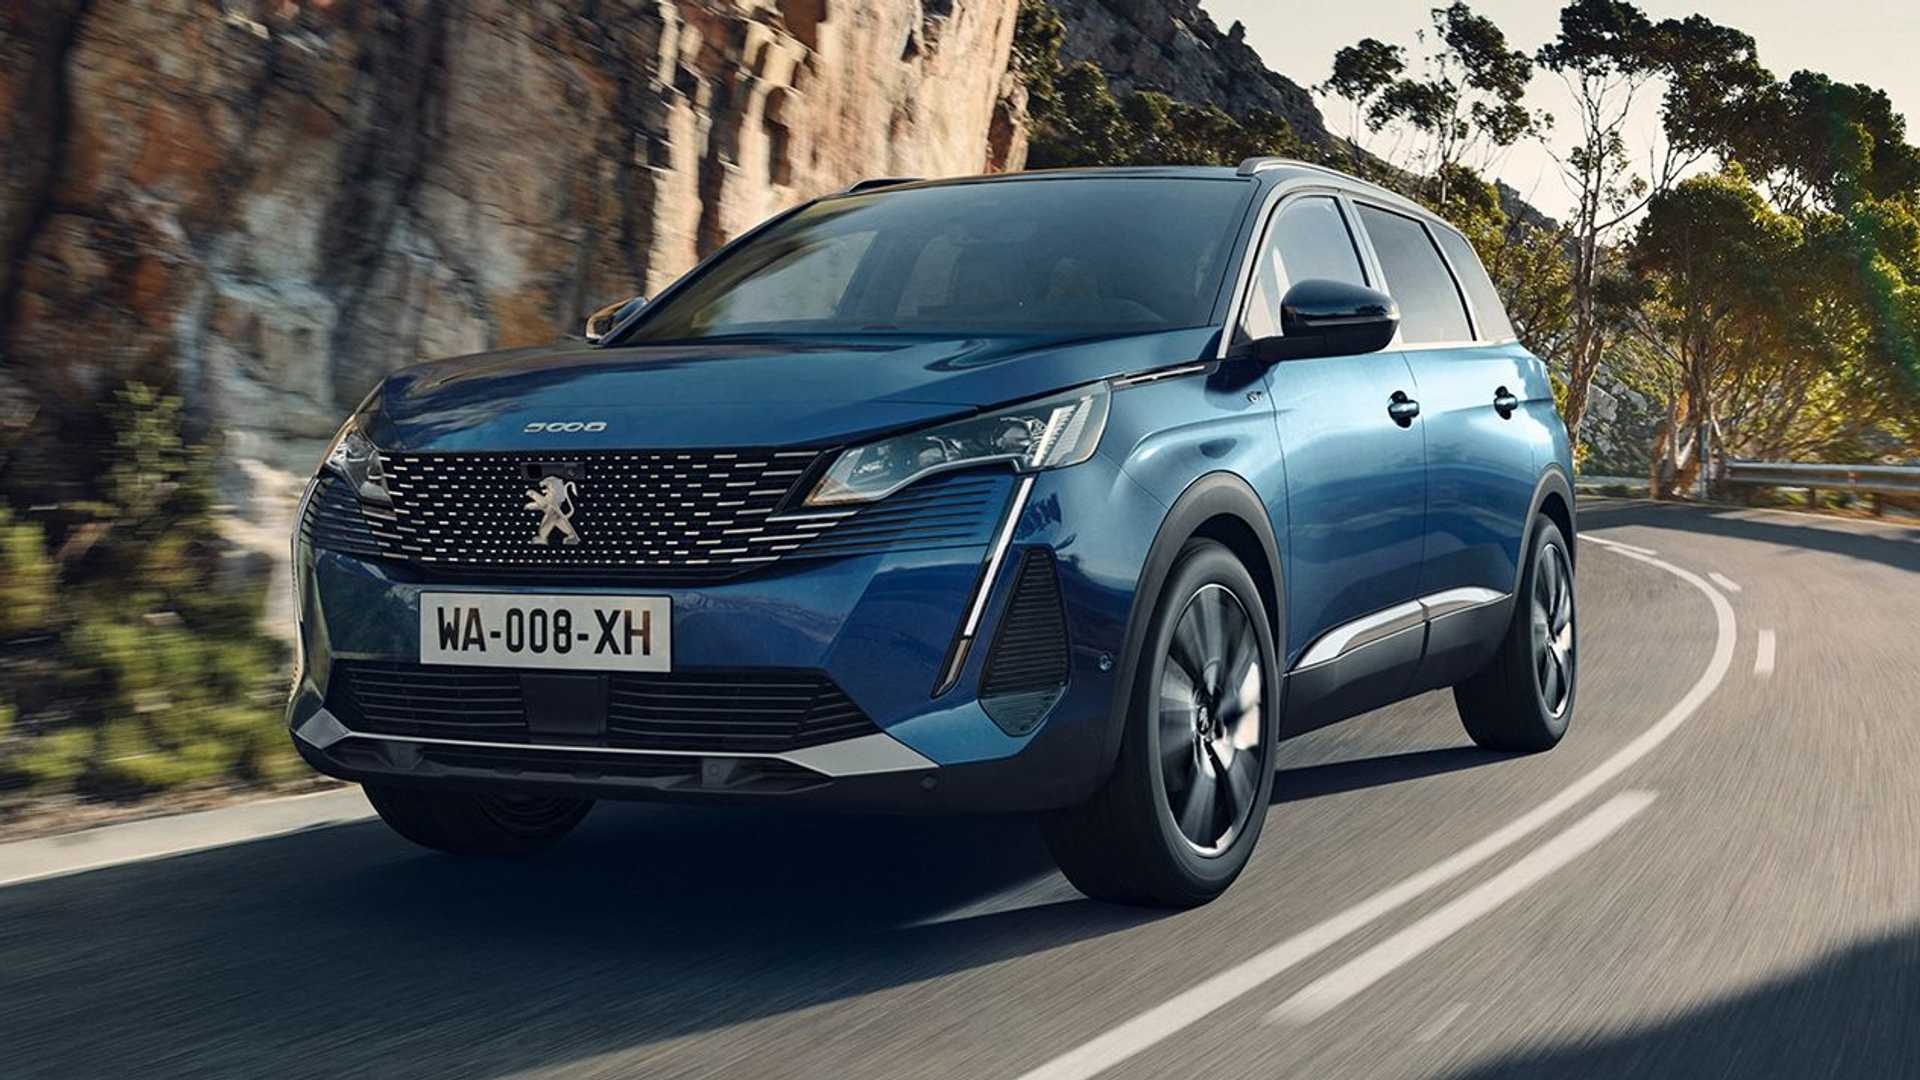

In [401]:
from IPython.display import Image
Image(filename=image_file)

In [402]:
import requests

# URL for the web service
scoring_uri = aks_service.scoring_uri
# If the service is authenticated, set the key or token
key, _ = aks_service.get_keys()
# Load image data
data = open(image_file, 'rb').read()
# Set the content type
headers = {'Content-Type': 'application/octet-stream'}
# If authentication is enabled, set the authorization header
headers['Authorization'] = f'Bearer {key}'
# Make the request and display the response
resp = requests.post(scoring_uri, data, headers=headers)
print("Status code=",resp.status_code)
print("Elapsed=", resp.elapsed)

Status code= 200
Elapsed= 0:00:00.582479


In [403]:
import json
detections = json.loads(resp.text) # Loadind the predictions from the computer vision model
for detect in detections['boxes']:
    label = detect['label']
    box = detect['box']
    conf_score = detect['score']

LicencePlate: [395.528, 590.317, 284.94, 86.646], 0.813


<Figure size 1296x864 with 0 Axes>

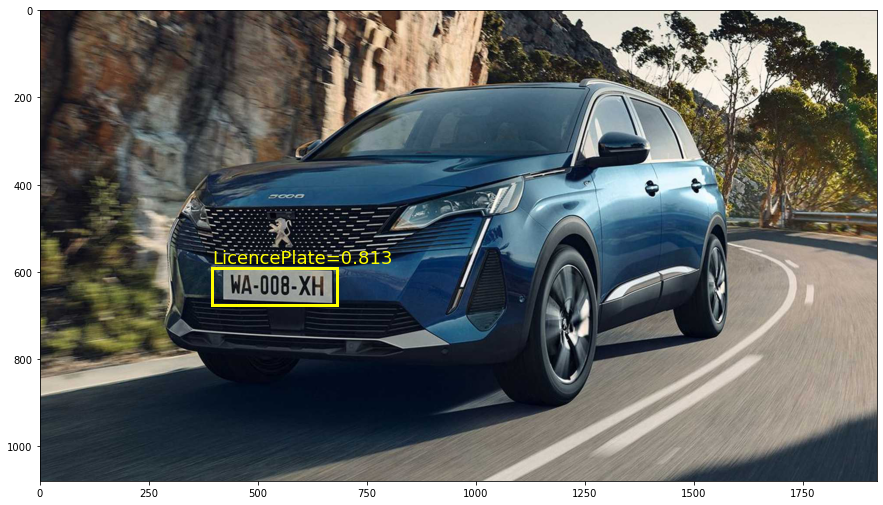

In [404]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import json

IMAGE_SIZE = (18,12)
plt.figure(figsize=IMAGE_SIZE)
img_np=mpimg.imread(image_file)
img = Image.fromarray(img_np.astype('uint8'),'RGB')
x, y = img.size

fig,ax = plt.subplots(1, figsize=(15,15)) #You can change the size

# Display the image
ax.imshow(img_np)

minscore=0.5

# draw box and label for each detection 
detections = json.loads(resp.text) # Loadind the predictions from the computer vision model
for detect in detections['boxes']:
    label = detect['label']
    box = detect['box']
    conf_score = detect['score']
    if conf_score >= minscore: #Min probability
        ymin, xmin, ymax, xmax =  box['topY'],box['topX'], box['bottomY'],box['bottomX']
        topleft_x, topleft_y = x * xmin, y * ymin
        width, height = x * (xmax - xmin), y * (ymax - ymin)
        print('{}: [{}, {}, {}, {}], {}'.format(detect['label'], round(topleft_x, 3), 
                                                round(topleft_y, 3), round(width, 3), 
                                                round(height, 3), round(conf_score, 3)))

        color = 'yellow' #You can change the color
        rect = patches.Rectangle((topleft_x, topleft_y), width, height, 
                                 linewidth=3, edgecolor=color,facecolor='none')
        textdisp=label+'='+str(round(conf_score, 3))
        ax.add_patch(rect)
        plt.text(topleft_x, topleft_y - 10, textdisp, color=color, fontsize=18)
        
        fig.savefig('predictioncar1.jpg', dpi=150) #Saving image
        
plt.show()

### 9.2 Test 2

In [405]:
# Download images files
image_url = 'https://github.com/retkowsky/AutoMLforImages/blob/main/images/car2.jpg?raw=true'
image_file = 'car2.jpg'
urllib.request.urlretrieve(image_url, filename=image_file)

('car2.jpg', <http.client.HTTPMessage at 0x7f726e4acf60>)

In [406]:
img = cv.imread(image_file)
print("Image informations:")
print("- Image filename:", image_file)
print("- Image shape:", img.shape)
print("- Image size:", img.size)

Image informations:
- Image filename: car2.jpg
- Image shape: (620, 930, 3)
- Image size: 1729800


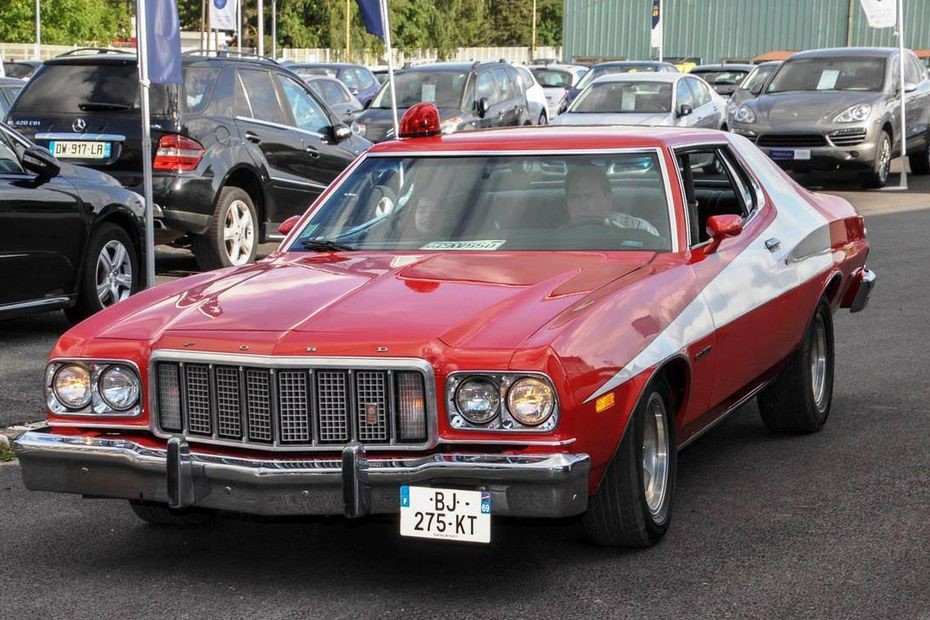

In [407]:
from IPython.display import Image
Image(filename=image_file)

In [408]:
import requests

# URL for the web service
scoring_uri = aks_service.scoring_uri
# If the service is authenticated, set the key or token
key, _ = aks_service.get_keys()
# Load image data
data = open(image_file, 'rb').read()
# Set the content type
headers = {'Content-Type': 'application/octet-stream'}
# If authentication is enabled, set the authorization header
headers['Authorization'] = f'Bearer {key}'
# Make the request and display the response
resp = requests.post(scoring_uri, data, headers=headers)
print("Status code=",resp.status_code)
print("Elapsed=", resp.elapsed)

Status code= 200
Elapsed= 0:00:00.547645


In [409]:
import json
detections = json.loads(resp.text) # Loadind the predictions from the computer vision model
for detect in detections['boxes']:
    label = detect['label']
    box = detect['box']
    conf_score = detect['score']

LicencePlate: [390.428, 483.818, 109.589, 61.365], 0.781


<Figure size 1296x864 with 0 Axes>

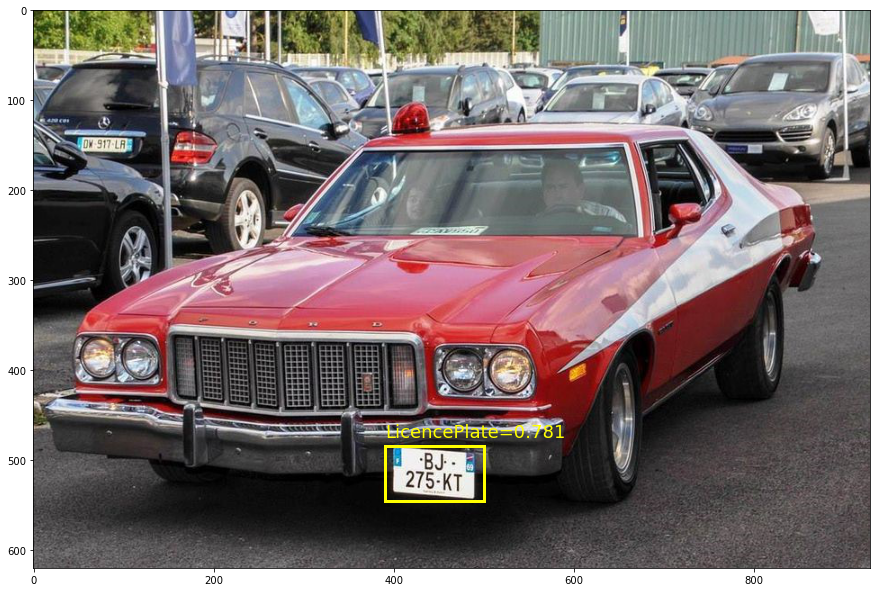

In [410]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import json

IMAGE_SIZE = (18,12)
plt.figure(figsize=IMAGE_SIZE)
img_np=mpimg.imread(image_file)
img = Image.fromarray(img_np.astype('uint8'),'RGB')
x, y = img.size

fig,ax = plt.subplots(1, figsize=(15,15)) #You can change the size

# Display the image
ax.imshow(img_np)

minscore=0.5

# draw box and label for each detection 
detections = json.loads(resp.text) # Loadind the predictions from the computer vision model
for detect in detections['boxes']:
    label = detect['label']
    box = detect['box']
    conf_score = detect['score']
    if conf_score >= minscore: #Min probability
        ymin, xmin, ymax, xmax =  box['topY'],box['topX'], box['bottomY'],box['bottomX']
        topleft_x, topleft_y = x * xmin, y * ymin
        width, height = x * (xmax - xmin), y * (ymax - ymin)
        print('{}: [{}, {}, {}, {}], {}'.format(detect['label'], round(topleft_x, 3), 
                                                round(topleft_y, 3), round(width, 3), 
                                                round(height, 3), round(conf_score, 3)))

        color = 'yellow' #You can change the color
        rect = patches.Rectangle((topleft_x, topleft_y), width, height, 
                                 linewidth=3, edgecolor=color,facecolor='none')
        textdisp=label+'='+str(round(conf_score, 3))
        ax.add_patch(rect)
        plt.text(topleft_x, topleft_y - 10, textdisp, color=color, fontsize=18)
        
        fig.savefig('predictioncar2.jpg', dpi=150) #Saving image
        
plt.show()

### 9.3 Test 3

In [411]:
# Download images files
image_url = 'https://github.com/retkowsky/AutoMLforImages/blob/main/images/car3.jpg?raw=true'
image_file = 'car3.jpg'
urllib.request.urlretrieve(image_url, filename=image_file)

('car3.jpg', <http.client.HTTPMessage at 0x7f726e4d4358>)

In [412]:
img = cv.imread(image_file)
print("Image informations:")
print("- Image filename:", image_file)
print("- Image shape:", img.shape)
print("- Image size:", img.size)

Image informations:
- Image filename: car3.jpg
- Image shape: (900, 1200, 3)
- Image size: 3240000


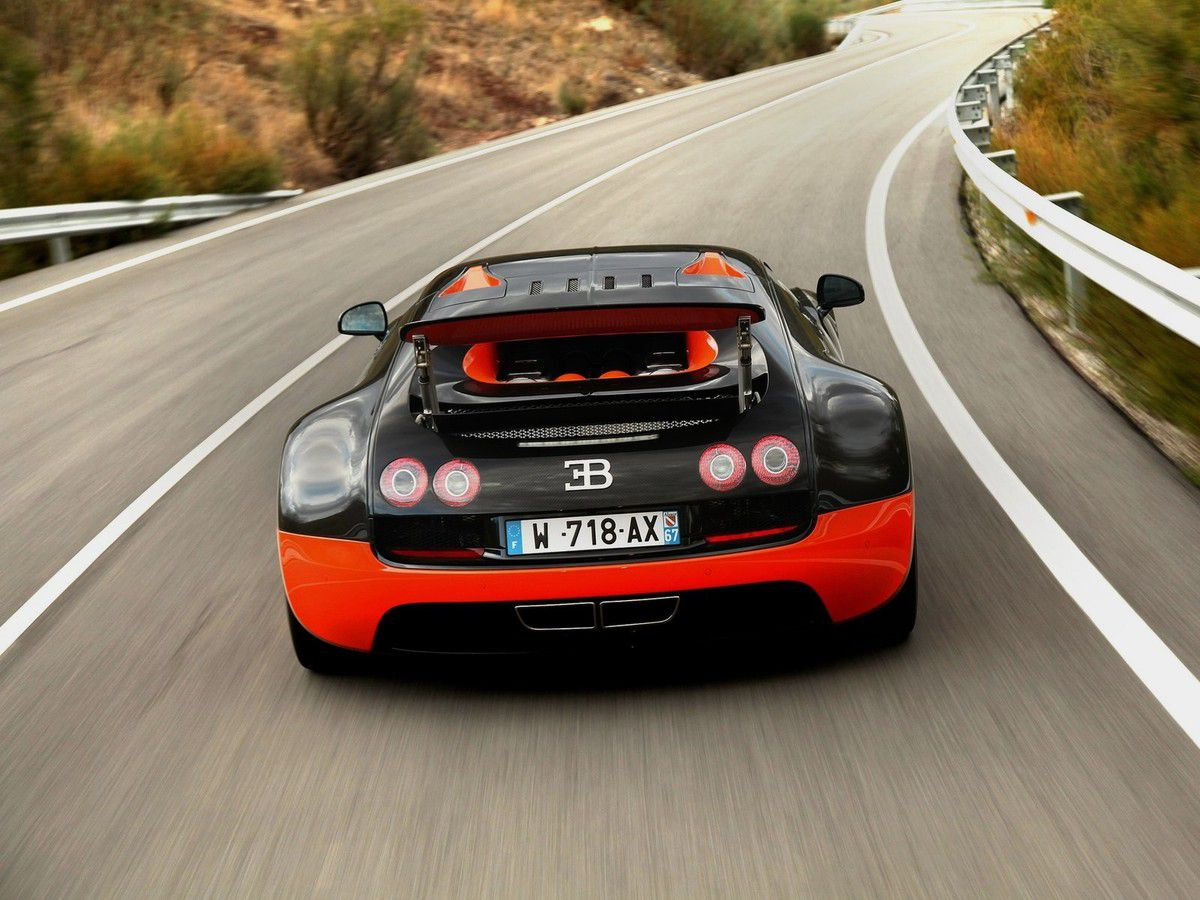

In [413]:
from IPython.display import Image
Image(filename=image_file)

In [414]:
import requests

# URL for the web service
scoring_uri = aks_service.scoring_uri
# If the service is authenticated, set the key or token
key, _ = aks_service.get_keys()
# Load image data
data = open(image_file, 'rb').read()
# Set the content type
headers = {'Content-Type': 'application/octet-stream'}
# If authentication is enabled, set the authorization header
headers['Authorization'] = f'Bearer {key}'
# Make the request and display the response
resp = requests.post(scoring_uri, data, headers=headers)
print("Status code=",resp.status_code)
print("Elapsed=", resp.elapsed)

Status code= 200
Elapsed= 0:00:00.565950


In [415]:
import json
detections = json.loads(resp.text) # Loadind the predictions from the computer vision model
for detect in detections['boxes']:
    label = detect['label']
    box = detect['box']
    conf_score = detect['score']

LicencePlate: [491.247, 504.566, 194.769, 60.546], 0.789


<Figure size 1296x864 with 0 Axes>

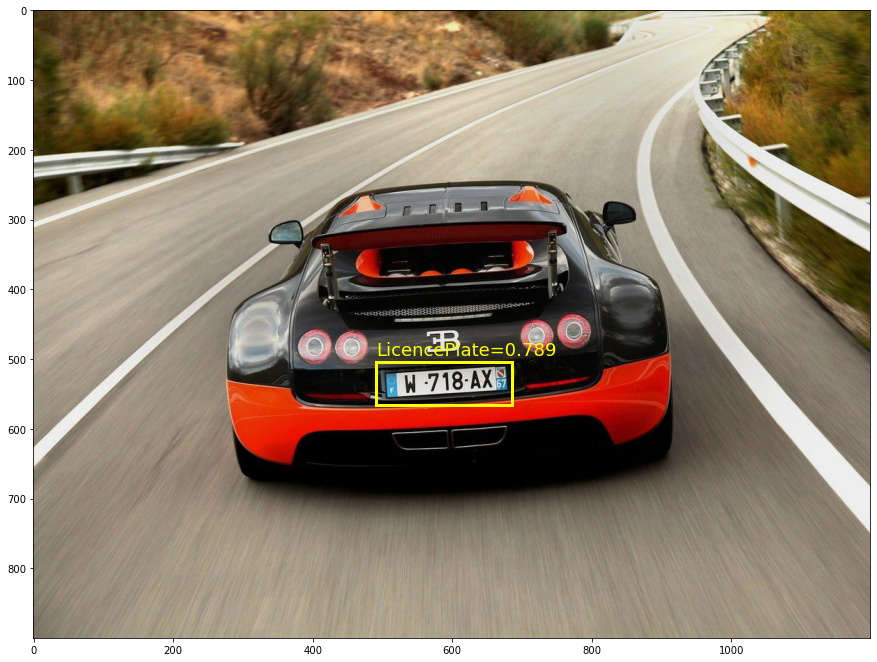

In [416]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import json

IMAGE_SIZE = (18,12)
plt.figure(figsize=IMAGE_SIZE)
img_np=mpimg.imread(image_file)
img = Image.fromarray(img_np.astype('uint8'),'RGB')
x, y = img.size

fig,ax = plt.subplots(1, figsize=(15,15)) #You can change the size

# Display the image
ax.imshow(img_np)

minscore=0.5

# draw box and label for each detection 
detections = json.loads(resp.text) # Loadind the predictions from the computer vision model
for detect in detections['boxes']:
    label = detect['label']
    box = detect['box']
    conf_score = detect['score']
    if conf_score >= minscore: #Min probability
        ymin, xmin, ymax, xmax =  box['topY'],box['topX'], box['bottomY'],box['bottomX']
        topleft_x, topleft_y = x * xmin, y * ymin
        width, height = x * (xmax - xmin), y * (ymax - ymin)
        print('{}: [{}, {}, {}, {}], {}'.format(detect['label'], round(topleft_x, 3), 
                                                round(topleft_y, 3), round(width, 3), 
                                                round(height, 3), round(conf_score, 3)))

        color = 'yellow' #You can change the color
        rect = patches.Rectangle((topleft_x, topleft_y), width, height, 
                                 linewidth=3, edgecolor=color,facecolor='none')
        textdisp=label+'='+str(round(conf_score, 3))
        ax.add_patch(rect)
        plt.text(topleft_x, topleft_y - 10, textdisp, color=color, fontsize=18)
        
        fig.savefig('predictioncar3.jpg', dpi=150) #Saving image
        
plt.show()

## 10. Let's use Azure OCR to identify the licence plate number on the licence plate extracted region

In [417]:
# Download images files
image_url = 'https://github.com/retkowsky/AutoMLforImages/blob/main/images/car4.jpg?raw=true'
image_file = 'car4.jpg'
urllib.request.urlretrieve(image_url, filename=image_file)

('car4.jpg', <http.client.HTTPMessage at 0x7f726e4b4940>)

In [418]:
img = cv.imread(image_file)
print("Image informations:")
print("- Image filename:", image_file)
print("- Image shape:", img.shape)
print("- Image size:", img.size)

Image informations:
- Image filename: car4.jpg
- Image shape: (1080, 1920, 3)
- Image size: 6220800


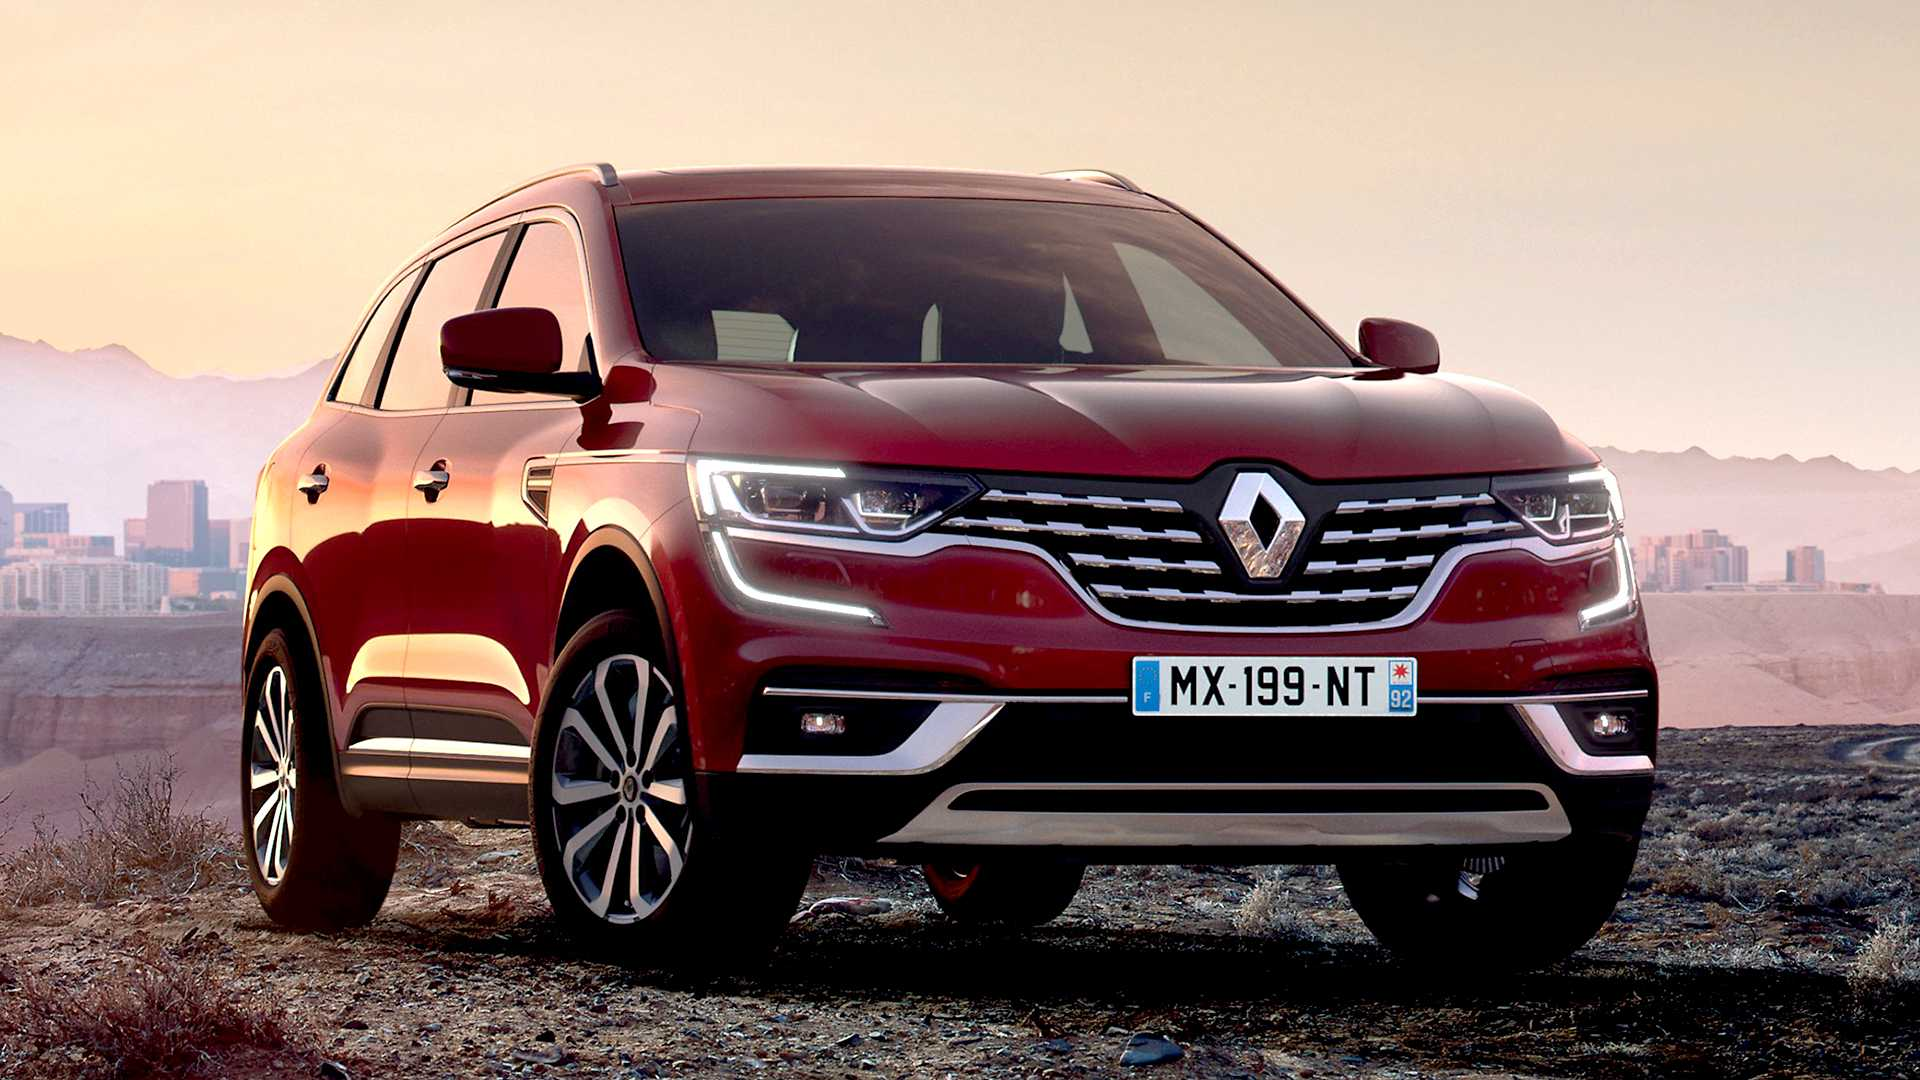

In [419]:
from IPython.display import Image
Image(filename=image_file)

In [420]:
# URL for the web service
scoring_uri = aks_service.scoring_uri
# If the service is authenticated, set the key or token
key, _ = aks_service.get_keys()
# Load image data
data = open(image_file, 'rb').read()
# Set the content type
headers = {'Content-Type': 'application/octet-stream'}
# If authentication is enabled, set the authorization header
headers['Authorization'] = f'Bearer {key}'
# Make the request and display the response
resp = requests.post(scoring_uri, data, headers=headers)

In [421]:
detections = json.loads(resp.text) # Loadind the predictions from the computer vision model
for detect in detections['boxes']:
    label = detect['label']
    box = detect['box']
    conf_score = detect['score']

LicencePlate: [1120.291, 643.937, 306.627, 90.141], 0.811


<Figure size 1296x864 with 0 Axes>

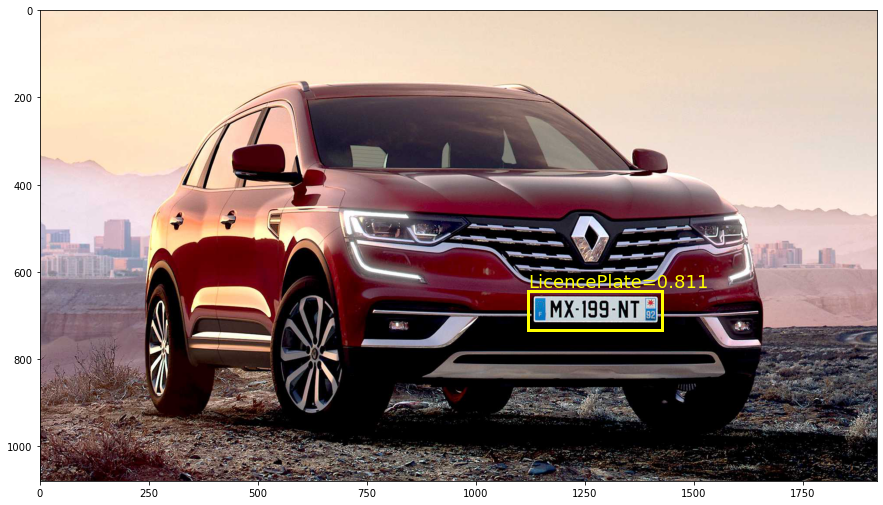

In [422]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import json

IMAGE_SIZE = (18,12)
plt.figure(figsize=IMAGE_SIZE)
img_np=mpimg.imread(image_file)
img = Image.fromarray(img_np.astype('uint8'),'RGB')
x, y = img.size

fig,ax = plt.subplots(1, figsize=(15,15)) #You can change the size

# Display the image
ax.imshow(img_np)

minscore=0.5

# draw box and label for each detection 
detections = json.loads(resp.text) # Loadind the predictions from the computer vision model
for detect in detections['boxes']:
    label = detect['label']
    box = detect['box']
    conf_score = detect['score']
    if conf_score >= minscore: #Min probability
        ymin, xmin, ymax, xmax =  box['topY'],box['topX'], box['bottomY'],box['bottomX']
        topleft_x, topleft_y = x * xmin, y * ymin
        width, height = x * (xmax - xmin), y * (ymax - ymin)
        print('{}: [{}, {}, {}, {}], {}'.format(detect['label'], round(topleft_x, 3), 
                                                round(topleft_y, 3), round(width, 3), 
                                                round(height, 3), round(conf_score, 3)))

        color = 'yellow' #You can change the color
        rect = patches.Rectangle((topleft_x, topleft_y), width, height, 
                                 linewidth=3, edgecolor=color,facecolor='none')
        textdisp=label+'='+str(round(conf_score, 3))
        ax.add_patch(rect)
        plt.text(topleft_x, topleft_y - 10, textdisp, color=color, fontsize=18)
        
        fig.savefig('results.jpg', dpi=150) #Saving image
        
plt.show()

### Only the licence plate

In [423]:
x1=round(topleft_x)
y1=round(topleft_y)
x2=x1+round(width)
y2=y1+round(height)

In [424]:
import cv2
img = cv2.imread(image_file)

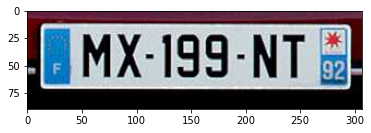

In [425]:
licenceplatefile="licenceplate.jpg" #Name of the cropping image

licenceplate= img[y1:y2, x1:x2] #Cropping image to have only the licence plate
plt.imshow(cv2.cvtColor(licenceplate, cv2.COLOR_BGR2RGB))
plt.savefig(licenceplatefile, dpi=150) #Saving image

### Transforms into gray

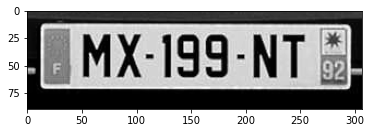

In [426]:
gray = cv2.cvtColor(licenceplate, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap='gray', vmin = 0, vmax = 255)
plt.savefig('licenceplategray.jpg', dpi=150) #Saving image
plt.show()

### Edge transformation

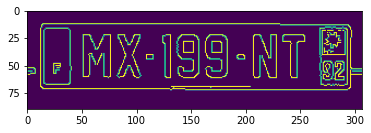

In [427]:
gray = cv2.bilateralFilter(gray, 13, 15, 15) 
edged = cv2.Canny(gray, 30, 200) 
plt.imshow(edged)
plt.savefig('licenceplateedge.jpg', dpi=150) #Saving image
plt.show()

### Azure OCR to read the licence plate number for the extracted image

In [428]:
#!pip install azure-cognitiveservices-vision-computervision

In [429]:
ocr_key = 'tobereplaced'
ocr_endpoint = 'https://computervsionreadapi.cognitiveservices.azure.com/' #To be replaced

In [430]:
# convert the cv2 image to bytes array so we can send it over the wire to the API 
crop_bytes =bytes(cv2.imencode('.jpg', gray)[1])

In [431]:
# make a call to the text_recognition_url
text_recognition_url = ocr_endpoint + "vision/v2.1/read/core/asyncBatchAnalyze"
response = requests.post(
    url=text_recognition_url, 
    data=crop_bytes, 
    headers={'Ocp-Apim-Subscription-Key': ocr_key, 'Content-Type': 'application/octet-stream'})

In [432]:
# Holds the URI used to retrieve the recognized text.
response.raise_for_status()
operation_url = response.headers["Operation-Location"]

In [433]:
# The recognized text isn't immediately available, so poll to wait for completion.
import time
analysis = {}
poll = True
while (poll):
    response_final = requests.get(
        response.headers["Operation-Location"], headers={'Ocp-Apim-Subscription-Key': ocr_key})
    analysis = response_final.json()
    print(analysis)
    time.sleep(1)
    if ("recognitionResults" in analysis):
        poll = False
    if ("status" in analysis and analysis['status'] == 'Failed'):
        poll = False

{'status': 'Running'}
{'status': 'Succeeded', 'recognitionResults': [{'page': 1, 'clockwiseOrientation': 358.85, 'width': 307, 'height': 90, 'unit': 'pixel', 'lines': [{'boundingBox': [22, 47, 31, 46, 32, 58, 22, 59], 'text': 'F', 'words': [{'boundingBox': [24, 46, 30, 45, 31, 58, 25, 59], 'text': 'F'}]}, {'boundingBox': [50, 19, 256, 19, 255, 63, 49, 63], 'text': 'MX - 199-NT', 'words': [{'boundingBox': [50, 20, 98, 20, 98, 64, 51, 63], 'text': 'MX'}, {'boundingBox': [106, 20, 114, 20, 115, 64, 106, 64], 'text': '-'}, {'boundingBox': [123, 20, 254, 20, 254, 64, 123, 64], 'text': '199-NT', 'confidence': 'Low'}]}, {'boundingBox': [268, 45, 292, 45, 294, 65, 269, 66], 'text': '92', 'words': [{'boundingBox': [272, 45, 293, 44, 293, 65, 272, 66], 'text': '92'}]}]}]}


### OCR results

In [434]:
print("The licence plate is:\n")
for i,l in enumerate(analysis['recognitionResults'][0]['lines']): 
    ocr=[w['text'] for w in l['words']]
    print("- OCR part", i+1, '=' , ocr)

The licence plate is:

- OCR part 1 = ['F']
- OCR part 2 = ['MX', '-', '199-NT']
- OCR part 3 = ['92']


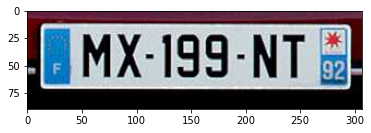

In [435]:
licenceplatefile="licenceplate.jpg" #Name of the cropping image
plt.imshow(cv2.cvtColor(licenceplate, cv2.COLOR_BGR2RGB))

### The licence plate image:

## 11. Cleanup ressources

In [285]:
# Let's delete the service
aks_service.delete()

# Let's delete our Azure ML GPU compute cluster
compute_target.delete()